In [1]:
import odrive
import time
import serial
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
odrv0 = odrive.find_any() # PATCH neededed !!!
print(str(odrv0.vbus_voltage))

40.86408615112305


In [3]:
# Configure Power Supply

odrv0.config.dc_bus_overvoltage_trip_level = 56 # [V]
odrv0.config.dc_bus_undervoltage_trip_level = 32 # [V]
odrv0.config.dc_max_positive_current = 7.8 # [A]
odrv0.config.dc_max_negative_current = -2 # [A]

In [4]:
# Motor Configuration

odrv0.axis0.config.motor.motor_type = 0 # HIGH_CURRENT
odrv0.axis0.config.motor.torque_constant = 8.27 / 100
odrv0.axis0.config.motor.pole_pairs = 20
odrv0.axis0.config.motor.current_soft_max = 50
odrv0.axis0.config.motor.current_hard_max = 70
odrv0.axis0.config.motor.calibration_current = 10
odrv0.axis0.config.motor.resistance_calib_max_voltage = 2
odrv0.axis0.config.calibration_lockin.current = 10

odrv0.axis0.requested_state = 4 # MOTOR_CALIBRATION

print(f"Phase resistance: {odrv0.axis0.config.motor.phase_resistance} Ohm")
print(f"Phase inductance: {odrv0.axis0.config.motor.phase_inductance} H")

odrv0.save_configuration() # saving the configuration

Phase resistance: 0.034226663410663605 Ohm
Phase inductance: 1.5217111467791256e-05 H


False

In [5]:
# Setting the Limits

odrv0.axis0.controller.config.vel_limit = 25 # [turn/s]
odrv0.axis0.controller.config.vel_limit_tolerance = 1.8 # [turn/s]
odrv0.axis0.config.torque_soft_min = -4 # [Nm]
odrv0.axis0.config.torque_soft_max = 4 # [Nm]

# BUT THERMISTORS ARE NOT SET UP
#odrv0.axis0.motor_thermistor.config.temp_limit_lower = 100 # °C (adapt this to your motor)
#odrv0.axis0.motor_thermistor.config.temp_limit_upper = 120 # °C (adapt this to your motor)

In [6]:
# Encoder Configuration

odrv0.axis0.config.load_encoder = 13 # ONBOARD_ENCODER0
odrv0.axis0.config.commutation_encoder = 13 # ONBOARD_ENCODER0
#time.sleep(5)
#odrv0.save_configuration()
# [wait for ODrive to reboot]

In [7]:
odrv0.axis0.requested_state = 7 # ENCODER_OFFSET_CALIBRATION
# [wait for motor to stop]

In [9]:
start_pos = odrv0.axis0.pos_vel_mapper.pos_rel
print(f"Encoder position: {start_pos}")

Encoder position: 0.17568039894104004


In [15]:
# Setting up the control loop

odrv0.axis0.requested_state = 8 # CLOSED_LOOP_CONTROL
odrv0.axis0.controller.config.input_mode = 1 # PASSTHROUGH
odrv0.axis0.controller.config.control_mode = 3 # POSITION_CONTROL

# baselin gains
# odrv0.axis0.controller.config.pos_gain = 20.0
# odrv0.axis0.controller.config.vel_gain = 0.16
# odrv0.axis0.controller.config.vel_integrator_gain = 0.32

odrv0.axis0.controller.config.pos_gain = 20.0*1.3**4
odrv0.axis0.controller.config.vel_gain = 0.5*(0.16*1.3**9)
odrv0.axis0.controller.config.vel_integrator_gain = 0#0.32

ser = serial.Serial('COM11', 115200, timeout=0.050)

In [9]:
def log_signals(startTime, startPos, Time, Pos, Vel, Trq):
    Time.append(time.time() - startTime) # time from start [s]
    Pos.append((odrv0.axis0.pos_vel_mapper.pos_rel - startPos)*2*np.pi) # rel. pos [rad]
    Vel.append(odrv0.axis0.pos_vel_mapper.vel*2*np.pi) # vel. [rad/s]
    Trq.append(odrv0.axis0.motor.torque_estimate) # estim. motor torque [Nm]
    return Time, Pos, Vel, Trq

In [18]:
startPos = odrv0.axis0.pos_vel_mapper.pos_rel
startTime = time.time()
currTime = 0

Ampl = 30/360  # [turns]
omega = 2*np.pi*(3/1)

Time = []
Pos = []
Vel = []
Trq = []
DesPos = []

endTime = 8
sampling_freq = 1/100
samplings = np.linspace(0, endTime, num=int(endTime/sampling_freq + 1))
count = 0

while currTime < endTime:
    currTime = time.time() - startTime
    desPos = Ampl*(np.sin(omega*currTime)) + startPos
    strCommand = f"p 0 {desPos}\r"
    ser.write(strCommand.encode(encoding="ascii"))
    if currTime >= samplings[count]:
        Time, Pos, Vel, Trq = log_signals(startTime, startPos, Time, Pos, Vel, Trq)
        DesPos.append((desPos - startPos)*2*np.pi)
        count += 1

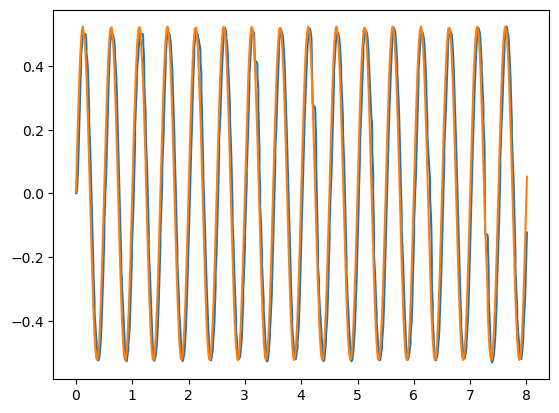

In [17]:
Timen = np.array(Time)
Posn = np.array(Pos)
DesPosn = np.array(DesPos)
Veln = np.array(Vel)
Trqn = np.array(Trq)
Data = np.column_stack((Timen, Posn, DesPosn, Veln, Trqn))
df = pd. DataFrame(Data)
#df. to_csv('baseline.csv', index=False)

plt.plot(Time, Pos)
plt.plot(Time, DesPos)
plt.show()

In [19]:
#odrv0. clear_errors()
odrv0.axis0.requested_state = 1 # IDLE
ser.close()
#strCommand

In [6]:
startTime = time.time()
currTime = 0

while currTime < 10:
    currTime = time.time() - startTime
    desPos = np.sin(currTime)
    print(f"Time: {currTime:.2f} sec, pos: {desPos:.4f} turn")
    time.sleep(0.8)

Time: 0.00 sec, pos: 0.0 turn
Time: 0.81 sec, pos: 0.7244 turn
Time: 1.63 sec, pos: 0.9984 turn
Time: 2.44 sec, pos: 0.6433 turn
Time: 3.26 sec, pos: -0.1156 turn
Time: 4.08 sec, pos: -0.8049 turn
Time: 4.89 sec, pos: -0.9838 turn
Time: 5.70 sec, pos: -0.5489 turn
Time: 6.50 sec, pos: 0.2186 turn
Time: 7.32 sec, pos: 0.8583 turn
Time: 8.13 sec, pos: 0.962 turn
Time: 8.94 sec, pos: 0.4633 turn
Time: 9.76 sec, pos: -0.3264 turn
Time: 10.57 sec, pos: -0.9105 turn


In [ ]:
#odrv = odrv0
#odrv.config.dc_bus_overvoltage_trip_level = 56
#odrv.config.dc_bus_undervoltage_trip_level = 32
#odrv.config.dc_max_positive_current = 7.8
#odrv.config.dc_max_negative_current = -2
#odrv.axis0.config.motor.motor_type = MotorType.HIGH_CURRENT
#odrv.axis0.config.motor.torque_constant = 0.0827
#odrv.axis0.config.motor.pole_pairs = 20
#odrv.axis0.config.motor.current_soft_max = 50
#odrv.axis0.config.motor.current_hard_max = 70
#odrv.axis0.config.motor.calibration_current = 10
#odrv.axis0.config.motor.resistance_calib_max_voltage = 2
#odrv.axis0.config.calibration_lockin.current = 10
#odrv.axis0.controller.config.input_mode = InputMode.PASSTHROUGH
#odrv.axis0.controller.config.control_mode = ControlMode.POSITION_CONTROL
#odrv.axis0.controller.config.vel_limit = 25
#odrv.axis0.controller.config.vel_limit_tolerance = 1.8
#odrv.axis0.config.torque_soft_min = -4
#odrv.axis0.config.torque_soft_max = 4
#odrv.axis0.config.load_encoder = EncoderId.ONBOARD_ENCODER0
#odrv.axis0.config.commutation_encoder = EncoderId.ONBOARD_ENCODER0